In [30]:
import copy
import os
import pickle
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

sys.path.append('..')
from utils.nn import FFNN

In [31]:
DATA = '../daily/data'
N_MODS = 3

False


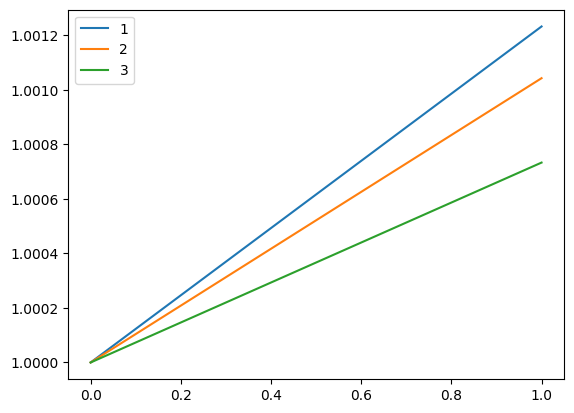

In [32]:
N_NEEDED = 3

perf1 = np.array([99860, 99983])
perf2 = np.array([99790, 99894])
perf3 = np.array([99616, 99689])

MUTATE = len(perf1) - 1 >= N_NEEDED
print(MUTATE)

buying_power = [181770, 187294, 187585]

plt.plot(perf1 / perf1[0], label='1')
plt.plot(perf2 / perf2[0], label='2')
plt.plot(perf3 / perf3[0], label='3')
plt.legend();

In [33]:
BEST = 2  # [1, 2, 3]
MUTATE_SCALE = 0.5

In [34]:
metrics = pd.read_csv(f'{DATA}/stock_metrics.csv')
metrics.head()

,stock,price,direction,RSI,RSIRev,fair_value_mult,geomean,sharpe
0,AAON,81.940002,0,0.037600,0.962400,0.033015,0.012552,0.679901
1,AAPL,235.740005,0,0.261200,0.738800,0.247812,0.237238,0.888844
2,ABBV,211.539993,1,0.953600,0.046400,0.944312,0.817155,0.799051
3,ABNB,142.580002,0,0.578244,0.421756,0.387006,0.671642,0.236570
4,ABT,137.710007,1,0.884000,0.116000,0.810660,0.830544,0.656569


In [35]:
x = metrics[['direction', 'RSI', 'fair_value_mult', 'geomean', 'sharpe']]

In [36]:
states = [None] * N_MODS
try:
    with open(f'{DATA}/ffnn_states.pkl', 'rb') as f:
        states = pickle.load(f)
        print('States recovered')
except FileNotFoundError:
    print('Creating new states...')
    states = [None] * N_MODS

States recovered


In [37]:
len(states)

3

In [38]:
mods = []
for state in states:
    mod = FFNN(**state) if state is not None else FFNN(5, [5])
    mods.append(mod)

In [39]:
if MUTATE:
    print('mutating..')
    best_state = mods[BEST - 1].get_state()
    mods = [mods[BEST - 1]]

    for _ in range(1, N_MODS):
        new_mod = FFNN(**copy.deepcopy(best_state))
        new_mod.mutate(scale=MUTATE_SCALE)
        mods.append(new_mod)
else:
    print('do nothing')

do nothing


In [40]:
len(mods)

3

In [41]:
#for mod in mods:
#    print(mod.Ws)

In [42]:
def get_holdings(filename, i):
    df = pd.read_csv(f'~/Downloads/ffnn/{filename}')
    df = df[['Symbol', 'Value']]
    df.Value = df.Value.str.replace('$', '').str.replace(',', '').astype(float)
    df.columns = ['stock', f'holdings{i + 1}']
    df.set_index('stock', drop=True, inplace=True)
    return df

In [43]:
holdings_files = sorted([f for f in os.listdir('/Users/damiansp/Downloads/ffnn') if f.endswith('.csv')])
holdings = pd.concat([get_holdings(f, i) for i, f in enumerate(holdings_files)], axis=1)
holdings.fillna(0, inplace=True)
holdings.head()

,holdings1,holdings2,holdings3
stock,,,
ABBV,634.62,0.00,0.00
ABT,550.84,0.00,0.00
AJG,681.58,0.00,0.00
AVGO,766.32,383.16,574.74
BABA,705.15,0.00,0.00


In [44]:
out = pd.DataFrame({'stock': metrics.stock, 'price': metrics.price.round(2)})
cols = []
for i, mod in enumerate(mods):
    value = mod.forward_pass(x, 'relu', 'sigmoid')
    value = value.squeeze()
    value /= np.sum(value)
    col = pd.Series(value, name=f'val{i + 1}')
    cols.append(col)
out = pd.concat([out, *cols], axis=1)
out.head()

,stock,price,val1,val2,val3
0,AAON,81.94,0.002950,0.003005,0.002822
1,AAPL,235.74,0.003328,0.003028,0.002966
2,ABBV,211.54,0.003298,0.002920,0.002957
3,ABNB,142.58,0.003131,0.002867,0.002980
4,ABT,137.71,0.003254,0.002911,0.002965


In [45]:
for h in [1, 2, 3]:
    invested_amt = holdings[f'holdings{h}'].sum()
    buying_power[h - 1] += invested_amt
print(buying_power)
amt_in = []
for i, d in enumerate(buying_power):
    amt = (d * out[f'val{i + 1}']).round(2)
    amt_in.append(pd.Series(amt, name=f'amt{i + 1}'))
out = pd.concat([out, *amt_in], axis=1)
out.set_index('stock', inplace=True, drop=True)
out.head()

[199965.61, 199789.13, 199379.06]


,price,val1,val2,val3,amt1,amt2,amt3
stock,,,,,,,
AAON,81.94,0.002950,0.003005,0.002822,589.89,600.40,562.70
AAPL,235.74,0.003328,0.003028,0.002966,665.48,605.00,591.36
ABBV,211.54,0.003298,0.002920,0.002957,659.44,583.47,589.55
ABNB,142.58,0.003131,0.002867,0.002980,626.05,572.80,594.20
ABT,137.71,0.003254,0.002911,0.002965,650.78,581.55,591.06


In [46]:
out = pd.concat([out, holdings], axis=1)
out.fillna(0, inplace=True)
out.head()

,price,val1,val2,val3,amt1,amt2,amt3,holdings1,holdings2,holdings3
stock,,,,,,,,,,
AAON,81.94,0.002950,0.003005,0.002822,589.89,600.40,562.70,0.00,0.0,0.0
AAPL,235.74,0.003328,0.003028,0.002966,665.48,605.00,591.36,0.00,0.0,0.0
ABBV,211.54,0.003298,0.002920,0.002957,659.44,583.47,589.55,634.62,0.0,0.0
ABNB,142.58,0.003131,0.002867,0.002980,626.05,572.80,594.20,0.00,0.0,0.0
ABT,137.71,0.003254,0.002911,0.002965,650.78,581.55,591.06,550.84,0.0,0.0


In [47]:
for i in range(N_MODS):
    out[f'diff{i + 1}'] = out[f'amt{i + 1}'] - out[f'holdings{i + 1}']
out.head()

,price,val1,val2,val3,amt1,amt2,amt3,holdings1,holdings2,holdings3,diff1,diff2,diff3
stock,,,,,,,,,,,,,
AAON,81.94,0.002950,0.003005,0.002822,589.89,600.40,562.70,0.00,0.0,0.0,589.89,600.40,562.70
AAPL,235.74,0.003328,0.003028,0.002966,665.48,605.00,591.36,0.00,0.0,0.0,665.48,605.00,591.36
ABBV,211.54,0.003298,0.002920,0.002957,659.44,583.47,589.55,634.62,0.0,0.0,24.82,583.47,589.55
ABNB,142.58,0.003131,0.002867,0.002980,626.05,572.80,594.20,0.00,0.0,0.0,626.05,572.80,594.20
ABT,137.71,0.003254,0.002911,0.002965,650.78,581.55,591.06,550.84,0.0,0.0,99.94,581.55,591.06


In [48]:
out = out[((out.price.notnull()) & (out.price > 0))]

In [49]:
for i in range(N_MODS):
    out[f'shares{i + 1}'] = (out[f'diff{i + 1}'] / out.price).round().astype('Int64')
out = out[out.price >= 2]
out

,price,val1,val2,val3,amt1,amt2,amt3,holdings1,holdings2,holdings3,diff1,diff2,diff3,shares1,shares2,shares3
stock,,,,,,,,,,,,,,,,
AAON,81.94,0.002950,0.003005,0.002822,589.89,600.40,562.70,0.00,0.0,0.0,589.89,600.40,562.70,7,7,7
AAPL,235.74,0.003328,0.003028,0.002966,665.48,605.00,591.36,0.00,0.0,0.0,665.48,605.00,591.36,3,3,3
ABBV,211.54,0.003298,0.002920,0.002957,659.44,583.47,589.55,634.62,0.0,0.0,24.82,583.47,589.55,0,3,3
ABNB,142.58,0.003131,0.002867,0.002980,626.05,572.80,594.20,0.00,0.0,0.0,626.05,572.80,594.20,4,4,4
ABT,137.71,0.003254,0.002911,0.002965,650.78,581.55,591.06,550.84,0.0,0.0,99.94,581.55,591.06,1,4,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
XYL,129.67,0.003203,0.002951,0.002926,640.55,589.54,583.47,0.00,0.0,0.0,640.55,589.54,583.47,5,5,4
ZBRA,304.00,0.002675,0.002961,0.002828,534.82,591.58,563.90,0.00,0.0,0.0,534.82,591.58,563.90,2,2,2
ZG,75.15,0.002930,0.002811,0.002970,585.84,561.52,592.17,0.00,0.0,0.0,585.84,561.52,592.17,8,7,8


In [50]:
o = out.sort_values('diff1', ascending=False)[['price', 'diff1', 'shares1']]
o[o.shares1 != 0].head(10)

,price,diff1,shares1
stock,,,
KNSL,437.71,686.46,2
SMCI,38.90,685.34,18
CPRT,54.41,684.56,13
IONQ,22.63,684.31,30
V,352.68,683.15,2
COST,1047.75,682.91,1
RGTI,8.18,682.75,83
CTAS,205.29,682.31,3
AXON,534.96,680.70,1


In [23]:
o[o.shares1 != 0].tail(10)

,price,diff1,shares1
stock,,,
VTRS,9.48,134.21,14
ABT,137.71,99.94,1
XPEV,21.66,86.30,4
KO,70.08,84.51,1
NWN,41.66,21.95,1
CELH,25.77,19.35,1
UVE,21.66,18.66,1
RCAT,5.39,14.64,3
SHOP,106.15,-56.58,-1


In [24]:
o = out.sort_values('diff2', ascending=False)[['price', 'diff2', 'shares2']]
o[o.shares2 != 0].head(10)

,price,diff2,shares2
stock,,,
UPST,59.93,608.41,10
RGTI,8.18,608.16,74
ANET,87.82,608.07,7
AMZN,208.36,608.01,3
JBL,143.14,607.96,4
HUBS,698.33,607.86,1
ARES,163.00,607.85,4
LFMD,4.99,607.68,122
BROS,70.59,607.49,9


In [26]:
o[o.shares2 != 0].tail(10)

,price,diff2,shares2
stock,,,
RCAT,5.39,280.42,52
HHH,77.56,280.31,4
CELH,25.77,274.17,11
IONQ,22.63,268.81,12
NVDA,117.30,258.47,2
PLTR,90.13,249.25,3
HII,193.59,237.51,1
AVGO,191.58,226.33,1
CTAS,205.29,195.32,1


In [27]:
o = out.sort_values('diff3', ascending=False)[['price', 'diff3', 'shares3']]
o[o.shares3 != 0].head(10)

,price,diff3,shares3
stock,,,
JBL,143.14,602.13,4
TEAM,276.73,601.29,2
SMCI,38.90,601.09,15
AMZN,208.36,600.96,3
UPST,59.93,600.93,10
HUBS,698.33,600.84,1
COF,185.95,600.56,3
UI,332.89,600.53,2
AXON,534.96,600.40,1


In [28]:
o[o.shares3 != 0].tail(10)

,price,diff3,shares3
stock,,,
STZ,174.18,403.36,2
VTRS,9.48,395.68,42
PII,41.23,393.12,10
WIT,3.32,389.42,117
HII,193.59,362.89,2
SAIC,102.63,359.48,4
NOVT,142.67,107.35,1
RCAT,5.39,9.32,2
RGTI,8.18,-19.91,-2


In [29]:
if MUTATE:
    states = [mod.get_state() for mod in mods]

    with open(f'{DATA}/ffnn_states.pkl', 'wb') as f:
        pickle.dump(states, f)